In [1]:
# TODO and potential extensions
# Show margin by which the winner has won. Probably difficult though

# Borda and IRV: burying
# The chance of exaggerating a low-performing candidate
# To push down another candidate ("Dark horse plus 3 rivals")
# Rank the centrist higher than preferred

# Borda, Approval, and Score: Compromising
# Raise 2nd choice over 1st, to get rid of even less favourable 3rd choice
# Or approves an additional candidate, to get him above another less favourable one

# Borda
# Voters may not rank all candidates. What happens to them? Applies to IRV as well
# Can also bullet vote by ranking only one candidate
# Modified Borda (see wikipedia) reduces incentive to bullet vote:
# points depend on number of candidates ranked, not on number of candidates running

# Score and Approval, and later no harm
# Chances of tactical bullet voting
# Approving one candidate can cause it to overtake a more preferred one
# Among acceptable candidates, who should be marked as approved on the ballot?
# Chance of voters not approving the furthest candidate
# Also, chances of voters ranking (d_sorted), then approving top 3 or top half

In [2]:
using StatsBase
using Distributions
using ProgressMeter

In [3]:
function fptp(distance_list)
    fptp_votes = argmin.(eachrow(distance_list))
    winner = StatsBase.countmap(fptp_votes)
    collectkeys = collect(keys(winner))
    collectvalues = collect(values(winner))
    return collectkeys[argmax(collectvalues)]
end

fptp (generic function with 1 method)

In [4]:
function approval(distance_list, a=0, b=1)
    # TODO: implement probability of bullet voting
    approval_radii = rand(Distributions.LogNormal(0,0.5), size(distance_list)[1])
    approval_list = distance_list .<= approval_radii
    winner = argmax(count.(eachcol(approval_list)))
    return winner
end

approval (generic function with 3 methods)

In [5]:
function sorter(distance_list)
    cols = size(distance_list)[1]
    rows = size(distance_list)[2]
    arr = zeros(Int64, (cols, rows))
    x = collect(eachrow(distance_list))
    for i in 1:size(arr)[1]
        arr[i, :] .= sortperm(x[i])
    end
    return arr
end

sorter (generic function with 1 method)

In [6]:
function borda(distance_list)    
    unfolded = sorter(distance_list)
    borda_count = StatsBase.countmap.(eachcol(unfolded))
    # columns are candidates, rows are their borda scores to be summed
    res = fill(0, size(candidate_x_coord)[2], size(borda_count)[1])

    for i in 1:size(borda_count)[1]
        for (k,v) in borda_count[i]
            # res[row][column]
            res[i, k] = v*i
        end
    end

    borda_sum = sum(res,dims=1)
    borda_winner = argmin(borda_sum)[2]
    return borda_winner
end

borda (generic function with 1 method)

In [7]:
function score(distance_list)
    # TODO: variable score radii -- why not use Approval's LogNormal?
    # each 'bin' gets a higher mean? but some values might be lower than the prev bin
    # rand(Distributions.LogNormal(0,0.5), 1)
    distlst = replace!(x -> x<=0.5 ? 10 : x, distance_list)
    distlst = replace!(x -> x>3 && x!=10 ? 0 : x, distance_list)
    distlst = replace!(x -> 0.5<x<=1 ? 8 : x, distance_list)
    distlst = replace!(x -> 1<x<=2 ? 7 : x, distance_list)
    distlst = replace!(x -> 2<x<=3 ? 5 : x, distance_list)
    score_sum = sum(distlst, dims=1)
    score_winner_pos = argmax(score_sum)[2]
    return score_winner_pos
end

score (generic function with 1 method)

In [8]:
function irv(distance_list)
    unfolded = sorter(distance_list)
    first_pref = unfolded[:,1]

    while true
        bincount = StatsBase.countmap(first_pref)
        collectkeys = collect(keys(bincount))
        collectvalues = collect(values(bincount))
        pos_of_max = collectkeys[argmax(collectvalues)]

        if bincount[pos_of_max] >= sum(collectvalues)/2
            return pos_of_max
        else
            lowest_cand = collectkeys[argmin(collectvalues)][1]
            @inbounds for i in 1:size(findall(first_pref.==lowest_cand))[1]
                row_num = findnext(first_pref.==lowest_cand, i)
                first_pref[row_num] = unfolded[row_num, 2]
            end
        end
    end
end

irv (generic function with 1 method)

In [9]:
function election(voter_mean_x, voter_mean_y, stdev, number_of_voters, candidate_x_coord, candidate_y_coord)
    v_x = rand(Distributions.Normal(voter_mean_x, stdev), number_of_voters)
    v_y = rand(Distributions.Normal(voter_mean_y, stdev), number_of_voters)

    distance_list = hypot.(v_x .- candidate_x_coord, # diff_x
                           v_y .- candidate_y_coord) # diff_y

    fptp_winner::Integer = fptp(distance_list)
    approval_winner::Integer = approval(distance_list)
    borda_winner::Integer = borda(distance_list)
    irv_winner::Integer = irv(distance_list) # There's a bizzare bug where calling score() first will mess up this function's order
    score_winner::Integer = score(distance_list)

    return (fptp_winner, approval_winner, borda_winner, irv_winner, score_winner)
end

election (generic function with 1 method)

In [10]:
using DataFrames
function loop_elections(voter_grid, candidate_x_coord, candidate_y_coord, number_of_voters=1000, stdev=1)
    voter_grid_tup_arr = vec(collect(voter_grid))
    voter_grid_size = size(voter_grid_tup_arr)[1]
    fptp_winner, approval_winner, borda_winner, irv_winner, score_winner = zeros(Integer, voter_grid_size), zeros(Integer, voter_grid_size), zeros(Integer, voter_grid_size), zeros(Integer, voter_grid_size), zeros(Integer, voter_grid_size)
    a, b = zeros(Float64, voter_grid_size), zeros(Float64, voter_grid_size)

    @showprogress for i in 1:voter_grid_size
        t1::Integer, t2::Integer, t3::Integer, t4::Integer, t5::Integer = election(voter_grid_tup_arr[i][1], voter_grid_tup_arr[i][2], stdev, number_of_voters, candidate_x_coord, candidate_y_coord)
        fptp_winner[i] = t1::Integer
        approval_winner[i] = t2::Integer
        borda_winner[i] = t3::Integer
        irv_winner[i] = t4::Integer
        score_winner[i] = t5::Integer
        
        a[i] = voter_grid_tup_arr[i][1]
        b[i] = voter_grid_tup_arr[i][2]
    end
    
    vdf = DataFrame()
    vdf.FPTP = fptp_winner
    vdf.Approval = approval_winner
    vdf.Borda = borda_winner
    vdf.IRV = irv_winner
    vdf.Score = score_winner
    vdf.x = a
    vdf.y = b
    return vdf
end

loop_elections (generic function with 3 methods)

In [11]:
using Plots
gr()

function plotter(df)
    p1 = plot(df.x, df.y, title="FPTP", seriestype=:scatter, color=df.FPTP, palette=[:red, :lightgreen, :blue], msw=0, markersize=2)
    plot!(candidate_x_coord, candidate_y_coord, seriestype=:scatter, palette=[:green, :blue, :red], msw=1, markersize=5, lims=(-2,2))
    p2 = plot(df.x, df.y, title="Approval", seriestype=:scatter, color=df.Approval, palette=[:red, :lightgreen, :blue], msw=0, markersize=2)
    plot!(candidate_x_coord, candidate_y_coord, seriestype=:scatter, palette=[:green, :blue, :red], msw=1, markersize=5, lims=(-2,2))
    p3 = plot(df.x, df.y, title="Borda", seriestype=:scatter, color=df.Borda, palette=[:red, :lightgreen, :blue], msw=0, markersize=2)
    plot!(candidate_x_coord, candidate_y_coord, seriestype=:scatter, palette=[:green, :blue, :red], msw=1, markersize=5, lims=(-2,2))
    p4 = plot(df.x, df.y, title="IRV", seriestype=:scatter, color=df.IRV, palette=[:red, :lightgreen, :blue], msw=0, markersize=2)
    plot!(candidate_x_coord, candidate_y_coord, seriestype=:scatter, palette=[:green, :blue, :red], msw=1, markersize=5, lims=(-2,2))
    p5 = plot(df.x, df.y, title="Score", seriestype=:scatter, color=df.Score, palette=[:red, :lightgreen, :blue], msw=0, markersize=2)
    plot!(candidate_x_coord, candidate_y_coord, seriestype=:scatter, palette=[:green, :blue, :red], msw=1, markersize=5, lims=(-2,2))
    final_plot = plot(p1, p2, p3, p4, p5, legend = false, size=((900,500)))
    return final_plot
end

plotter (generic function with 1 method)

In [12]:
const candidate_x_coord = [0.93 0.79 0.27]
const candidate_y_coord = [0.49 0.42 0.45]
const voter_grid = Iterators.product(-2:0.1:2, -2:0.1:2)
looped = loop_elections(voter_grid, candidate_x_coord, candidate_y_coord);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Please wait...


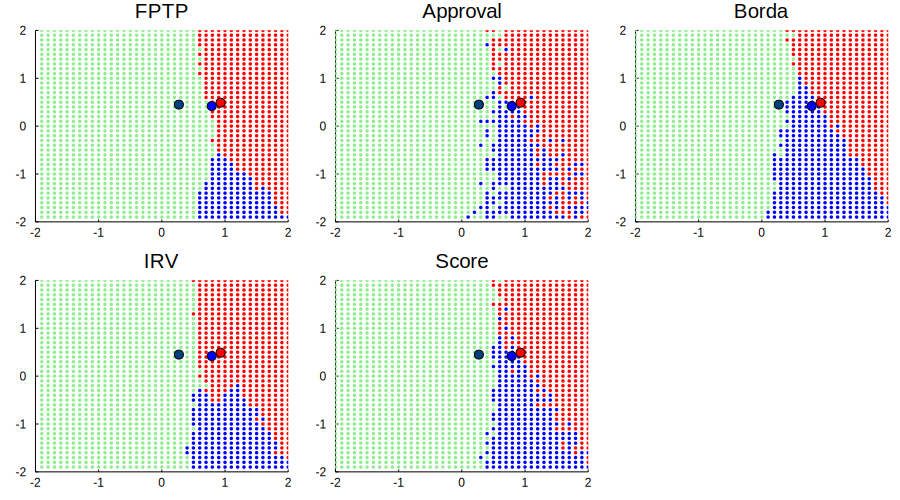

In [13]:
println("Please wait...")
chart = plotter(looped)

In [14]:
png(chart, "juliachart")

In [15]:
# TESTING
using Test

# Note: columns are candidates and rows are each voter
# The number is the distance between them
# So [1 2 3] means candidate 3 is furthest from this voter
                                   # d_sorted
test_distance_list = [[1 2 3];     # 1 2 3
                      [2 1 3];     # 2 1 3
                      [2 3 1];     # 3 1 2
                      [3 2 1];]    # 3 2 1

@testset "sorter" begin
    @test sorter(test_distance_list) ≈ [1 2 3; 2 1 3; 3 1 2; 3 2 1]
    @inferred sorter(test_distance_list)
end

@testset "FPTP" begin
    @test fptp(test_distance_list) ≈ 3
    @inferred fptp(test_distance_list)
end

@testset "Approval" begin
    @inferred approval(test_distance_list)
end

@testset "Borda" begin
    @test borda(test_distance_list) ≈ 1 #|| 2 || 3
    @inferred borda(test_distance_list)
end

@testset "IRV" begin
    @test irv(test_distance_list) ≈ 3
    @inferred irv(test_distance_list)
end

@testset "Score" begin
    @test score(test_distance_list) ≈ 1 #|| 2
    @inferred score(test_distance_list)
end

@testset "election functions" begin
    @inferred election(1, 1, 1, 100, [1 2 3], [3 2 1])
    @inferred loop_elections(Iterators.product(-2:1:2, -2:1:2), [1 2 3], [3 2 1])
end

Test Summary: | Pass  Total
sorter        |    1      1
Test Summary: | Pass  Total
FPTP          |    1      1
Test Summary: |
Approval      | No tests
Test Summary: | Pass  Total
Borda         |    1      1
Test Summary: | Pass  Total
IRV           |    1      1
Test Summary: | Pass  Total
Score         |    1      1
Test Summary:      |
election functions | No tests


Test.DefaultTestSet("election functions", Any[], 0, false)

In [16]:
@code_warntype borda(test_distance_list)
# this, irv(), and sorted() shows yellow on Union{Nothing, ...}
# This is just the loop over the iterator, which returns the next value, or nothing if at end

Variables
  #self#::Core.Compiler.Const(borda, false)
  distance_list::Array{Int64,2}
  unfolded::Array{Int64,2}
  borda_count::Array{Dict{Int64,Int64},1}
  res::Array{Int64,2}
  @_6::Union{Nothing, Tuple{Int64,Int64}}
  borda_sum::Array{Int64,2}
  borda_winner::Int64
  i::Int64
  @_10::Union{Nothing, Tuple{Pair{Int64,Int64},Int64}}
  k::Int64
  v::Int64
  @_13::Int64

Body::Int64
1 ─       Core.NewvarNode(:(borda_sum))
│         Core.NewvarNode(:(borda_winner))
│         (unfolded = Main.sorter(distance_list))
│   %4  = StatsBase.countmap::Core.Compiler.Const(StatsBase.countmap, false)
│   %5  = Main.eachcol(unfolded)::Base.Generator{Base.OneTo{Int64},Base.var"#176#177"{Array{Int64,2}}}
│   %6  = Base.broadcasted(%4, %5)::Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{1},Nothing,typeof(countmap),Tuple{Array{SubArray{Int64,1,Array{Int64,2},Tuple{Base.Slice{Base.OneTo{Int64}},Int64},true},1}}}
│         (borda_count = Base.materialize(%6))
│   %8  = Main.size(Main.candidate